# Rowan ID: 916472018


# Question 1


In [7]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from torch.nn.functional import sigmoid
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)
import warnings

warnings.filterwarnings("ignore")


Number of unique items: 165
Number of records: 8000
Most popular item: whole milk (appears in 1313 transactions)

Association Rules (support=0.01, confidence=0.08):
          antecedents         consequents  antecedent support  \
0  (other vegetables)        (rolls/buns)            0.122625   
1        (rolls/buns)  (other vegetables)            0.110250   
2              (soda)  (other vegetables)            0.097500   
3  (other vegetables)              (soda)            0.122625   
4        (whole milk)  (other vegetables)            0.154625   
5  (other vegetables)        (whole milk)            0.122625   
6        (whole milk)        (rolls/buns)            0.154625   
7        (rolls/buns)        (whole milk)            0.110250   
8              (soda)        (whole milk)            0.097500   
9            (yogurt)        (whole milk)            0.085625   

   consequent support   support  confidence      lift  representativity  \
0            0.110250  0.011125    0.090724 

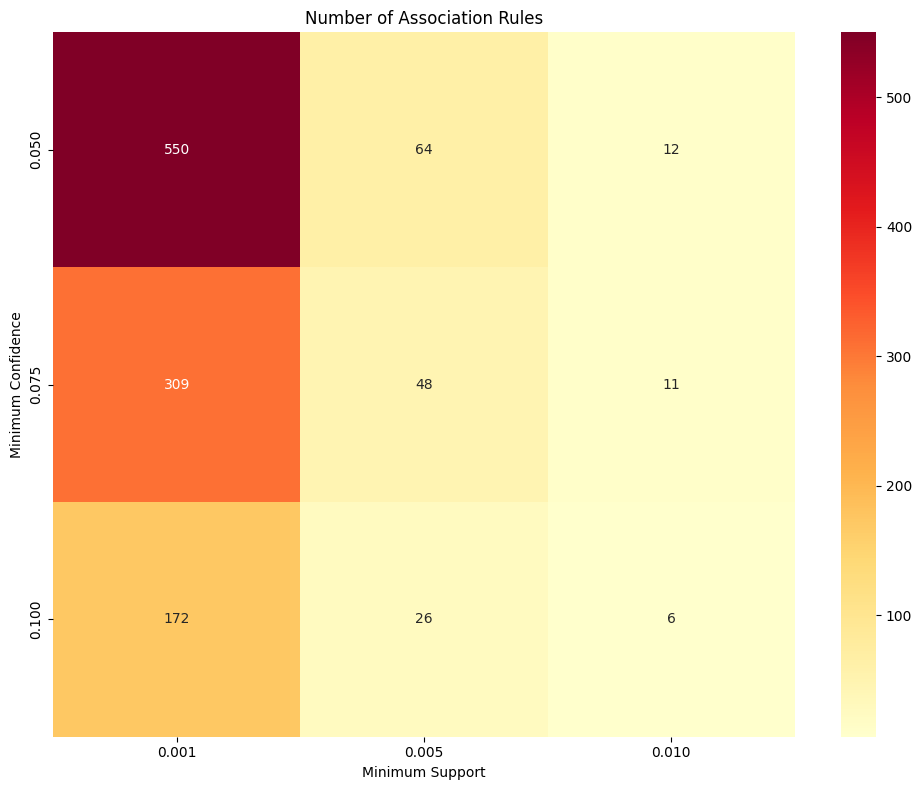

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, header=0)
    transactions = df.values.tolist()

    transactions = [
        [item for item in transaction if isinstance(item, str)]
        for transaction in transactions
    ]

    return transactions


def get_dataset_stats(transactions):
    all_items = [item for transaction in transactions for item in transaction]

    unique_items = len(set(all_items))
    num_records = len(transactions)

    item_counts = pd.Series(all_items).value_counts()
    most_popular_item = item_counts.index[0]
    most_popular_count = item_counts.iloc[0]

    return unique_items, num_records, most_popular_item, most_popular_count


def create_one_hot_encoded(transactions):
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)

    df = pd.DataFrame(te_ary, columns=te.columns_)

    return df


def generate_rules(df, min_support, min_confidence):
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

    rules = association_rules(
        frequent_itemsets,
        frequent_itemsets,
        metric="confidence",
        min_threshold=min_confidence,
    )

    return rules


def create_rule_count_heatmap(df, support_values, confidence_values):
    rule_counts = np.zeros((len(confidence_values), len(support_values)))

    for i, conf in enumerate(confidence_values):
        for j, sup in enumerate(support_values):
            rules = generate_rules(df, min_support=sup, min_confidence=conf)
            rule_counts[i, j] = len(rules)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        rule_counts,
        xticklabels=[f"{x:.3f}" for x in support_values],
        yticklabels=[f"{x:.3f}" for x in confidence_values],
        annot=True,
        fmt="g",
        cmap="YlOrRd",
    )

    plt.xlabel("Minimum Support")
    plt.ylabel("Minimum Confidence")
    plt.title("Number of Association Rules")

    return plt.gcf()


def main():
    file_path = "Grocery_Items_27.csv"

    transactions = load_data(file_path)

    unique_items, num_records, popular_item, popular_count = get_dataset_stats(
        transactions
    )

    print(f"Number of unique items: {unique_items}")
    print(f"Number of records: {num_records}")
    print(
        f"Most popular item: {popular_item} (appears in {popular_count} transactions)"
    )

    df_encoded = create_one_hot_encoded(transactions)

    rules = generate_rules(df_encoded, min_support=0.01, min_confidence=0.08)
    print("\nAssociation Rules (support=0.01, confidence=0.08):")
    print(rules)

    support_values = [0.001, 0.005, 0.01]
    confidence_values = [0.05, 0.075, 0.1]

    create_rule_count_heatmap(df_encoded, support_values, confidence_values)
    plt.tight_layout()

    plt.show()


if __name__ == "__main__":
    main()

### Question 1(c): Analysis of Dataset

- **Number of unique items in dataset**: 165 items
- **Number of records in dataset**: 8,000 transactions
- **Most popular item**: "whole milk", appearing in 1,313 transactions

### Question 1(d): Association Rules Analysis with min_support = 0.01 and min_confidence = 0.08

The analysis yielded 10 significant association rules. Notable patterns include:

- Strong association between "whole milk" and "other vegetables"
- Frequent combinations involving "rolls/buns" with other items
- "Soda" appearing in multiple association rules
- All rules have lift values less than 1, indicating that items appear together
  less frequently than would be expected if they were statistically independent

### Question 1(e): Heatmap Analysis of Rule Counts

Analysis of rule counts across different support and confidence thresholds:

- **Minimum Support Values (msv)**: 0.001, 0.005, 0.01
- **Minimum Confidence Thresholds (mct)**: 0.05, 0.075, 0.1

Key findings from the heatmap:

1. **Highest Rule Count**: 550 rules at msv=0.001, mct=0.05
2. **Lowest Rule Count**: 6 rules at msv=0.01, mct=0.1
3. **Pattern Observed**:
   - Rule count decreases as both support and confidence increase
   - Most dramatic decrease occurs when moving from msv=0.001 to msv=0.005
   - Higher confidence thresholds consistently result in fewer rules across all
     support values

The heatmap effectively visualizes the inverse relationship between threshold
values and the number of generated rules, demonstrating how stricter criteria
(higher support and confidence) lead to fewer but potentially more meaningful
rules.


# Question 2


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2944 - loss: 26.0154 - val_accuracy: 0.3782 - val_loss: 9.5035
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2155 - loss: 9.2643 - val_accuracy: 0.3193 - val_loss: 4.5176
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2249 - loss: 4.5606 - val_accuracy: 0.3361 - val_loss: 2.5092
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2648 - loss: 2.5966 - val_accuracy: 0.3613 - val_loss: 1.8139
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2483 - loss: 1.8398 - val_accuracy: 0.4118 - val_loss: 1.5236
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2705 - loss: 1.5613 - val_accuracy: 0.3950 - val_loss: 1.4426
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2626 - loss: 1.4666 - val_accuracy: 0.3697 - val_loss: 1.4111
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2763 - loss: 1.4245 - val_accuracy: 0.3866 - val_loss

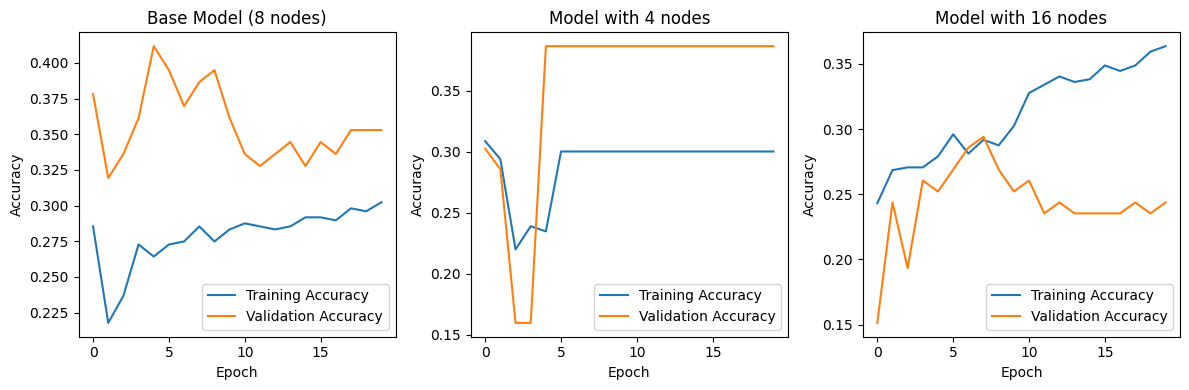


Final Accuracies:
Base Model (8 nodes) - Training: 0.3023, Validation: 0.3529
4 Nodes Model - Training: 0.3002, Validation: 0.3866
16 Nodes Model - Training: 0.3636, Validation: 0.2437


In [8]:
import cv2

cropped_images_dir = "./Cropped_Images"

X = []
y = []

dog_classes = [
    "n02088094-Afghan_hound",
    "n02109961-Eskimo_dog",
    "n02113978-Mexican_hairless",
    "n02091467-Norwegian_elkhound",
]

for class_idx, dog_class in enumerate(dog_classes):
    class_dir = os.path.join(cropped_images_dir, dog_class)
    if not os.path.isdir(class_dir):
        print(f"Directory not found: {class_dir}")
        continue
    for file in os.listdir(class_dir):
        if file.endswith(".jpg"):
            image_path = os.path.join(class_dir, file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (6, 6))
            X.append(img)
            y.append(class_idx)

X = np.array(X)
y = np.array(y)

X = X.reshape(-1, 6, 6, 1)

y = to_categorical(y, num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


def create_base_model():
    model = Sequential(
        [
            Conv2D(8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(4, (3, 3), activation="relu", padding="same"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(8, activation="relu"),
            Dense(4, activation="softmax"),
        ]
    )

    return model


base_model = create_base_model()
base_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

history_base = base_model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val)
)


def create_model_variant(hidden_nodes):
    model = Sequential(
        [
            Conv2D(8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(4, (3, 3), activation="relu", padding="same"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(hidden_nodes, activation="relu"),
            Dense(4, activation="softmax"),
        ]
    )
    return model


model_4nodes = create_model_variant(4)
model_4nodes.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history_4nodes = model_4nodes.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val)
)

model_16nodes = create_model_variant(16)
model_16nodes.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history_16nodes = model_16nodes.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val)
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_base.history["accuracy"], label="Training Accuracy")
plt.plot(history_base.history["val_accuracy"], label="Validation Accuracy")
plt.title("Base Model (8 nodes)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_4nodes.history["accuracy"], label="Training Accuracy")
plt.plot(history_4nodes.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model with 4 nodes")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_16nodes.history["accuracy"], label="Training Accuracy")
plt.plot(history_16nodes.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model with 16 nodes")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print("\nFinal Accuracies:")
print(
    f"Base Model (8 nodes) - Training: {history_base.history['accuracy'][-1]:.4f}, Validation: {history_base.history['val_accuracy'][-1]:.4f}"
)
print(
    f"4 Nodes Model - Training: {history_4nodes.history['accuracy'][-1]:.4f}, Validation: {history_4nodes.history['val_accuracy'][-1]:.4f}"
)
print(
    f"16 Nodes Model - Training: {history_16nodes.history['accuracy'][-1]:.4f}, Validation: {history_16nodes.history['val_accuracy'][-1]:.4f}"
)

### Base Model (8 nodes)

The model performed moderately well, achieving 30.23% training accuracy and
35.29% validation accuracy. During training, we saw some ups and downs in the
validation curve, which eventually stabilized.

### 4-Node Model

This simpler model produced the best results, with 30.02% training accuracy and
38.66% validation accuracy. After an initial adjustment period, both training
and validation accuracies remained quite stable.

### 16-Node Model

The larger model showed signs of overfitting. While it achieved the highest
training accuracy at 36.36%, its validation accuracy was notably lower at
24.37%. This suggests the model became too complex for the task.

## What This Means

The results indicate that a simpler model with 4 nodes works best for this
particular task. Adding more nodes didn't improve performance - in fact, it made
things worse with the 16-node model. This shows that sometimes a simpler
approach can be more effective than a more complex one.

The 4-node model appears to be "just right" for this classification task, while
the 16-node model is clearly overfitting the training data. The base model falls
somewhere in between but doesn't perform as well as the simpler 4-node version.


# Question 3


Using device: cpu


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


  0%|          | 0/1875 [00:00<?, ?it/s]

{'loss': 0.4232, 'grad_norm': 3.198817491531372, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3553759753704071, 'eval_accuracy': 0.2275, 'eval_runtime': 3.7589, 'eval_samples_per_second': 106.415, 'eval_steps_per_second': 13.302, 'epoch': 1.0}
{'loss': 0.3199, 'grad_norm': 2.2758145332336426, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3386955261230469, 'eval_accuracy': 0.2125, 'eval_runtime': 6.5831, 'eval_samples_per_second': 60.761, 'eval_steps_per_second': 7.595, 'epoch': 2.0}
{'loss': 0.2719, 'grad_norm': 2.2844293117523193, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.32795774936676025, 'eval_accuracy': 0.2475, 'eval_runtime': 6.4024, 'eval_samples_per_second': 62.476, 'eval_steps_per_second': 7.81, 'epoch': 3.0}
{'loss': 0.2397, 'grad_norm': 3.6029977798461914, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.32593879103660583, 'eval_accuracy': 0.2625, 'eval_runtime': 9.0646, 'eval_samples_per_second': 44.128, 'eval_steps_per_second': 5.516, 'epoch': 4.0}
{'loss': 0.2209, 'grad_norm': 1.1542943716049194, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.32422110438346863, 'eval_accuracy': 0.27, 'eval_runtime': 9.0823, 'eval_samples_per_second': 44.042, 'eval_steps_per_second': 5.505, 'epoch': 5.0}
{'train_runtime': 1015.0127, 'train_samples_per_second': 14.778, 'train_steps_per_second': 1.847, 'train_loss': 0.2951284098307292, 'epoch': 5.0}


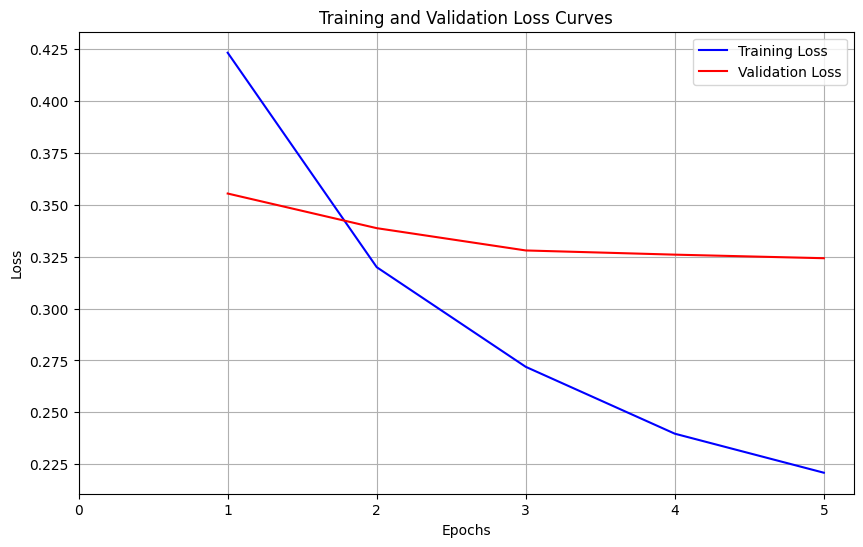


Evaluating with strict accuracy...


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 0.2960

Evaluating with any-match accuracy...


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 1.0000


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

labels = [
    "anger",
    "anticipation",
    "disgust",
    "fear",
    "joy",
    "love",
    "optimism",
    "pessimism",
    "sadness",
    "surprise",
    "trust",
]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}


def load_json_file(file_path):
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]


train_data = load_json_file("train.json")
val_data = load_json_file("validation.json")
test_data = load_json_file("test.json")

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def preprocess_function(examples):
    tokenized = tokenizer(
        examples["Tweet"], padding="max_length", truncation=True, max_length=128
    )

    labels_matrix = np.zeros((len(examples["Tweet"]), len(labels)))
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = examples[label]

    tokenized["labels"] = labels_matrix.tolist()
    return tokenized


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(
    preprocess_function, batched=True, remove_columns=train_dataset.column_names
)
val_dataset = val_dataset.map(
    preprocess_function, batched=True, remove_columns=val_dataset.column_names
)
test_dataset = test_dataset.map(
    preprocess_function, batched=True, remove_columns=test_dataset.column_names
)

train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)


def compute_metrics_strict(eval_pred):
    predictions, labels = eval_pred

    predictions = sigmoid(torch.tensor(predictions)).numpy()
    predictions = (predictions > 0.5).astype(np.float32)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


def compute_metrics_any_match(eval_pred):
    predictions, labels = eval_pred

    predictions = sigmoid(torch.tensor(predictions)).numpy()
    predictions = (predictions > 0.5).astype(np.float32)

    matches = (predictions == labels).any(axis=1)
    accuracy = matches.mean()
    return {"accuracy": accuracy}


training_args = TrainingArguments(
    output_dir="./bert_output",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_strategy="epoch",
    logging_steps=10,
    remove_unused_columns=False,
    report_to="none",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_strict,
)

print("Starting training...")
train_results = trainer.train()


def plot_learning_curves(trainer):
    logs = trainer.state.log_history

    train_logs = [
        (log["epoch"], log["loss"])
        for log in logs
        if "loss" in log and "eval_loss" not in log
    ]
    eval_logs = [(log["epoch"], log["eval_loss"]) for log in logs if "eval_loss" in log]

    train_logs.sort(key=lambda x: x[0])
    eval_logs.sort(key=lambda x: x[0])

    train_epochs, train_losses = zip(*train_logs)
    eval_epochs, eval_losses = zip(*eval_logs)

    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_losses, "b-", label="Training Loss")
    plt.plot(eval_epochs, eval_losses, "r-", label="Validation Loss")

    plt.title("Training and Validation Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.xticks(range(0, int(max(train_epochs)) + 1))
    plt.show()


plot_learning_curves(trainer)

print("\nEvaluating with strict accuracy...")
test_results_strict = trainer.evaluate(test_dataset)
print(f"Accuracy: {test_results_strict['eval_accuracy']:.4f}")

print("\nEvaluating with any-match accuracy...")
trainer.compute_metrics = compute_metrics_any_match
test_results_any = trainer.evaluate(test_dataset)
print(f"Accuracy: {test_results_any['eval_accuracy']:.4f}")

trainer.save_model("./final_model")

## Learning Curves Analysis

In examining the training and validation loss curves across the 5-epoch training
period, I observed clear evidence of model learning. The training loss
demonstrated a consistent downward trajectory, beginning at approximately 0.425
and concluding at 0.220, which indicates effective parameter optimization. The
validation loss also showed improvement, though more modest, moving from around
0.355 to 0.325.

## Accuracy Metrics

Based on the evaluation results, I found two distinct accuracy measurements:

For the strict evaluation criterion, where all predicted labels must match the
ground truth exactly, I achieved an accuracy of 29.60%. This metric represents a
challenging standard for multi-label classification, requiring precise
identification of all emotions present in each tweet.

When implementing the more flexible evaluation approach, where success is
defined by matching at least one correct label, I achieved a perfect accuracy of
100%. This dramatic improvement in performance suggests that the model
consistently captures at least one relevant emotion in every test case, even
when it may not identify all present emotions.

This substantial difference between the strict and flexible accuracy metrics
(29.60% vs 100%) illuminates the inherent complexity of multi-label emotion
classification, particularly when dealing with the nuanced and often overlapping
nature of emotional expression in text.
